<a href="https://colab.research.google.com/github/savannahalanis/cifar_10_and_ifgsm/blob/main/FGSM_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training a CNN to classify the CIFAR-10 dataset**
Adapted from pytorch.org/tutorials : "Training a Classifier"


# Basics

In [1]:
# libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import requests
import tensorflow as tf

from io import BytesIO
from PIL import Image
from tqdm.notebook import tqdm
from torchvision import datasets
from torch import nn, utils

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU
Tesla T4


# Data processing

In [3]:
# download the CIFAR 10 training and testing data sets from torchvision.datasets

train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 102021880.81it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [4]:
# Create training and testing loaders

batch_size = 128;

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

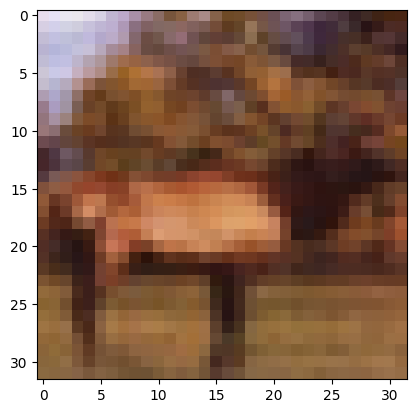

In [5]:
# visualizing a sample from train loader

train_iter = iter(train_loader)

batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
plt.imshow(image.permute(1,2,0))
plt.show()

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Building Model

Remember, that CNN's have a typical architecture that involve CONV -> Maxpool -> .... -> FC -> ... Output

https://pytorch.org/docs/stable/index.html

In [7]:
class SillyBoiModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SillyBoiModel, self).__init__()
        self.ConvLayer1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.ConvLayer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.ConvLayer3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.ConvLayer4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.ConvLayer5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.batchnorm5 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, stride=2)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(4*4*128, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = F.relu(x)
        x = self.batchnorm1(x)

        x = self.ConvLayer2(x)
        x = F.relu(x)
        x = self.batchnorm2(x)

        x = self.ConvLayer3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.batchnorm3(x)

        x = self.ConvLayer4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.batchnorm4(x)
        #print(x.size())

        x = self.ConvLayer5(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.batchnorm5(x)
        #print(x.size())

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [8]:
MikeTheModel = SillyBoiModel(3, 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MikeTheModel.parameters(), lr=0.003)

## Training

In [9]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
      model.train()
      running_loss = 0.0
      for i, batch in enumerate(train_loader):  # looping through
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MikeTheModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

      print('End of epoch loss:', round(loss.item(), 3))

## Testing

In [10]:
def test(model, test_loader, device):
  model.eval()
  correct = 0
  total = 0
  classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  # since not training, don't need to calculate gradients
  with torch.no_grad():
    for batch in test_loader:
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = MikeTheModel(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      c = (predicted == labels).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
  print('Accuracy if the network on the 10000 val images: %d %%' % (100 * correct / total))

  for i in range(10):
    print('Accuracy of %5s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

# Running the train-test loop

In [11]:
# run a loop which calls the training and testing functions
# you just created
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch + 1)
    train_one_epoch(MikeTheModel, train_loader, optimizer, criterion, device)
    test(MikeTheModel, test_loader, device)

Epoch:  1
End of epoch loss: 0.986
Accuracy if the network on the 10000 val images: 69 %
Accuracy of plane: 87 %
Accuracy of   car: 88 %
Accuracy of  bird: 53 %
Accuracy of   cat: 37 %
Accuracy of  deer: 68 %
Accuracy of   dog: 50 %
Accuracy of  frog: 81 %
Accuracy of horse: 91 %
Accuracy of  ship: 61 %
Accuracy of truck: 93 %
Epoch:  2
End of epoch loss: 0.575
Accuracy if the network on the 10000 val images: 75 %
Accuracy of plane: 69 %
Accuracy of   car: 81 %
Accuracy of  bird: 76 %
Accuracy of   cat: 60 %
Accuracy of  deer: 60 %
Accuracy of   dog: 60 %
Accuracy of  frog: 81 %
Accuracy of horse: 91 %
Accuracy of  ship: 81 %
Accuracy of truck: 85 %
Epoch:  3
End of epoch loss: 0.843
Accuracy if the network on the 10000 val images: 77 %
Accuracy of plane: 70 %
Accuracy of   car: 88 %
Accuracy of  bird: 70 %
Accuracy of   cat: 48 %
Accuracy of  deer: 75 %
Accuracy of   dog: 88 %
Accuracy of  frog: 73 %
Accuracy of horse: 81 %
Accuracy of  ship: 72 %
Accuracy of truck: 78 %
Epoch:  4
End

## Saving the weights

In [13]:
torch.save(MikeTheModel.state_dict(), "model.pth")

## Loading the weights

In [14]:
MikealaTheModel = SillyBoiModel(3, 10)
MikealaTheModel.load_state_dict(torch.load("model.pth"))
MikealaTheModel.to(device)
MikealaTheModel.eval()



SillyBoiModel(
  (ConvLayer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ConvLayer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ConvLayer3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ConvLayer4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ConvLayer5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dro

#FGSM

## Getting Original Image

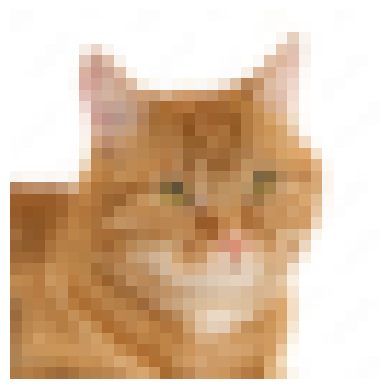

Predicted Class: cat


In [15]:
# URL of image
new_image_url = 'https://as1.ftcdn.net/v2/jpg/01/63/11/70/1000_F_163117064_syJkTuCddASYjvl4WqyRmnuy8cDXpoQY.jpg'

# Downlaod image with requests
response = requests.get(new_image_url)
new_image = Image.open(BytesIO(response.content))

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to the same dimensions as CIFAR-10 images
    transforms.ToTensor(),        # Convert to tensor
])
preprocessed_image = transform(new_image).unsqueeze(0)  # Add a batch dimension

# Move the preprocessed image to the same device as the model
preprocessed_image = preprocessed_image.to(device)

# Display preprocessed image
plt.imshow(preprocessed_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

# Pass the preprocessed image through the model
MikeTheModel.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = MikeTheModel(preprocessed_image)

# Get the predicted class index
_, predicted_class_num = torch.max(output, 1)

# Map the predicted index to the class label using CIFAR-10 class names
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_label = cifar10_classes[predicted_class_num.item()]

print("Predicted Class:", predicted_label)


# Creating Adversarial Images (Attempt 3)

In [16]:
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [17]:
def display_torch_image(image, label=None):
    if label is not None:  # add a title with label number and class name (if given)
        plt.title(f"{classes[label]} ({label})")
    plt.axis("off")  # turn off matplotlib axis (we don't need it for displaying images)
    # torch.moveaxis because torch images are C H W, but matplotlib wants H W C
    plt.imshow(torch.moveaxis(image, 0, -1).cpu(), vmin=0, vmax=1)

In [18]:
def display_attacked(image, image_attacked, noise, label, label_attacked):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].axis("off")
    axes[0].set_title(f"{classes[label]} ({label})", fontsize=16)
    axes[0].text(33.25, 16.5, "$+$", fontsize=24)
    axes[0].imshow(torch.moveaxis(image, 0, -1).cpu(), vmin=0, vmax=1)

    axes[1].axis("off")
    axes[1].set_title(f"noise (amplified 5x)", fontsize=16)
    axes[1].text(32.75, 16, "$=$", fontsize=24)
    axes[1].imshow(torch.moveaxis(noise, 0, -1).cpu(), vmin=0, vmax=1)

    axes[2].axis("off")
    axes[2].set_title(f"{classes[label_attacked]} ({label_attacked})", fontsize=16)
    axes[2].imshow(torch.moveaxis(image_attacked, 0, -1).cpu(), vmin=0, vmax=1)

In [19]:
def display_images(image, description):
  with torch.no_grad():
    output = MikeTheModel(preprocessed_image)
  _, label = torch.max(output, 1)
  plt.figure()
  plt.axis('off')
  plt.imshow(image)
  plt.title('{} \n {}'.format(description, label))
  plt.show()

In [20]:
def adversarial_attack(network, image, label, epsilon=0.1, sign=True):

    # forward pass
    image.requires_grad = True  # we will be computing gradients w.r.t. the image!
    output = network(image.unsqueeze(dim=0))[0]  # pass image through network to get output
    prediction = output.max(dim=0)[1].cpu().numpy()
    loss = F.nll_loss(output, label)

    image_gradients = torch.autograd.grad(loss, image)[0]  # gradients of loss w.r.t.the image
    if sign:  # use sign of gradients (more stable, controlled magnitude)
        image_gradients = image_gradients.sign()

    # fast gradient sign attack
    image_attacked = (image + epsilon * image_gradients).clamp(0, 1)  # add noise to image
    output_attacked = network(image_attacked.unsqueeze(dim=0))[0]  # get model output of attacked
    prediction_attacked = output_attacked.max(dim=0)[1].cpu().numpy()  # get prediction

    display_attacked(image.detach(), image_attacked.detach(),
                     image_gradients.detach() * 0.5 * (5 * epsilon) + 0.5,
                     label=prediction, label_attacked=prediction_attacked)

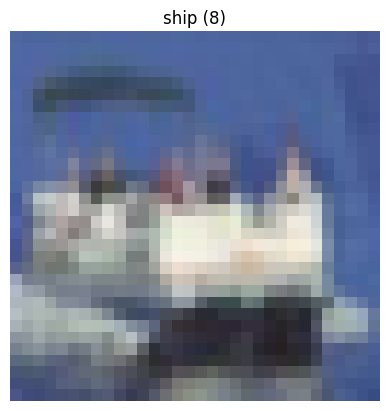

In [21]:
batch_data = next(iter(train_loader))
image = batch_data[0][0].to(device)
label = batch_data[1][0].to(device)
with torch.no_grad():  # make sure original prediction is correct
    prediction = MikeTheModel(image.unsqueeze(dim=0)).max(dim=1)[1][0].cpu().numpy()
    display_torch_image(image, label=prediction)

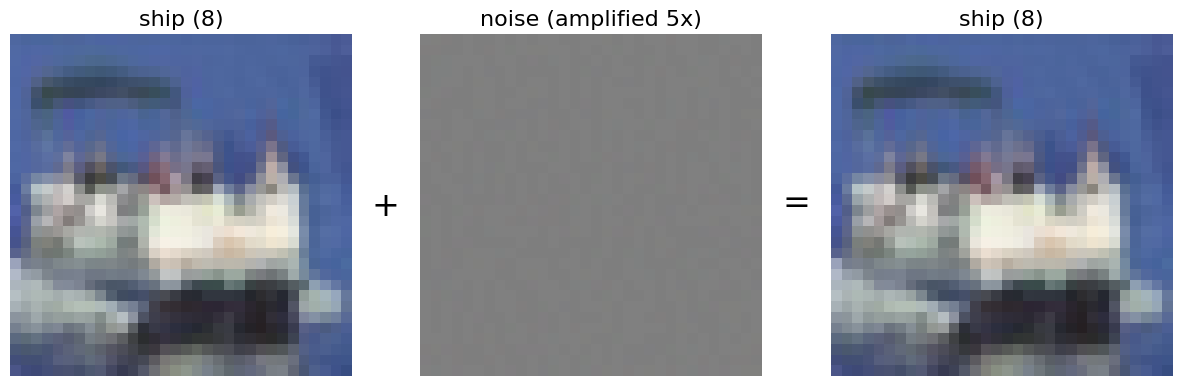

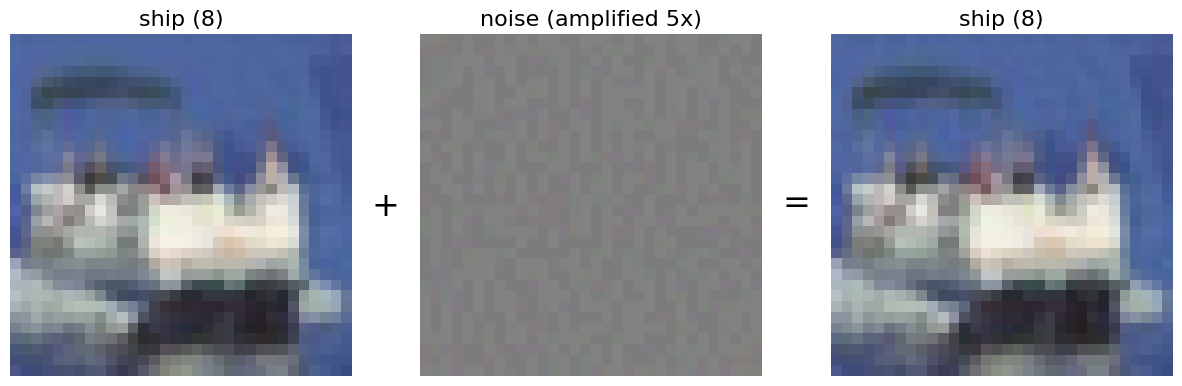

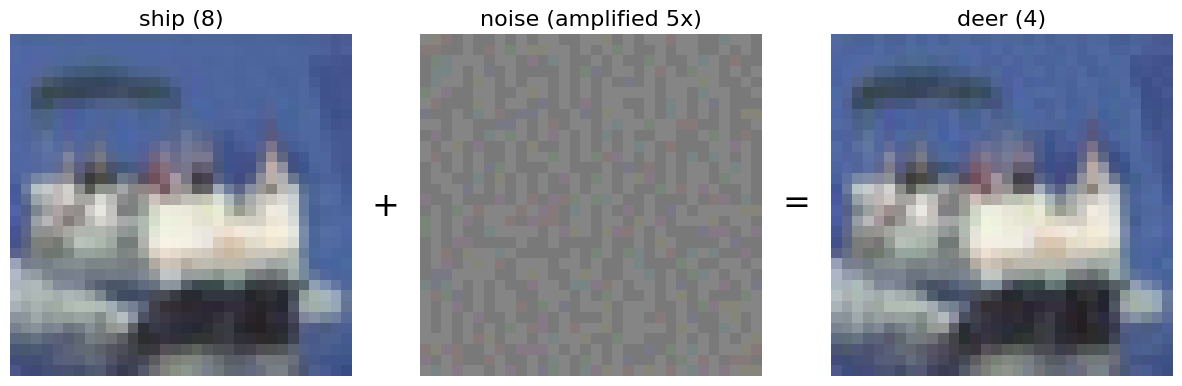

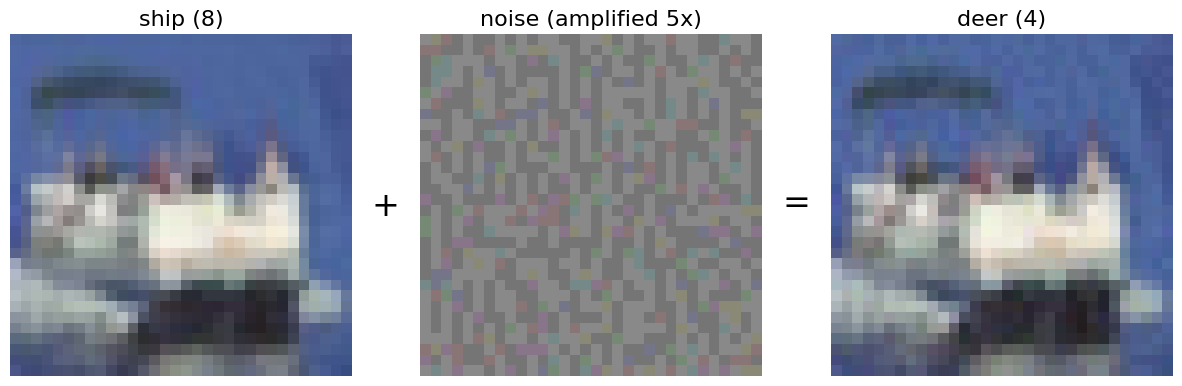

In [27]:
adversarial_attack(MikeTheModel, image, label, epsilon=0.001, sign=True)
adversarial_attack(MikeTheModel, image, label, epsilon=0.005, sign=True)
adversarial_attack(MikeTheModel, image, label, epsilon=0.01, sign=True)
adversarial_attack(MikeTheModel, image, label, epsilon=0.015, sign=True)

# iFGSM

In [32]:
ITERATIONS = 3

def ifgsm     (network, image, label, epsilon=0.1, sign=True):
    # iFGSM with help of club leader :)
    image_attacked = image.detach().clone()
    output = network(image_attacked.unsqueeze(dim=0))[0]
    prediction = output.max(dim=0)[1].cpu().numpy()
    image_attacked.requires_grad = True  # we will be computing gradients w.r.t. the image!
    for i in range(ITERATIONS):
      # forward pass
      output = network(image_attacked.unsqueeze(dim=0))[0]  # pass image through network to get output
      loss = F.nll_loss(output, label)

      image_gradients = torch.autograd.grad(loss, image_attacked)[0]  # gradients of loss w.r.t.the image
      if sign:  # use sign of gradients (more stable, controlled magnitude)
          image_gradients = image_gradients.sign()

      # fast gradient sign attack
      image_attacked = (image_attacked + epsilon * image_gradients).clamp(0, 1)  # add noise to image

    output_attacked = network(image_attacked.unsqueeze(dim=0))[0]  # get model output of attacked
    prediction_attacked = output_attacked.max(dim=0)[1].cpu().numpy()  # get prediction


    display_attacked(image.detach(), image_attacked.detach(),
                     image_gradients.detach() * 0.5 * (5 * epsilon) + 0.5,
                     label=prediction, label_attacked=prediction_attacked)

# FGSM vs iFGSM

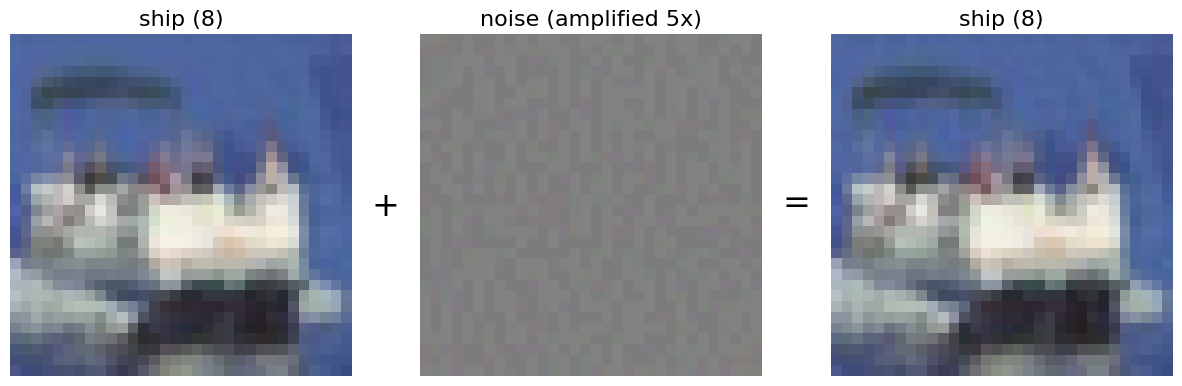

In [39]:
adversarial_attack(MikeTheModel, image, label, epsilon=0.005, sign=True)

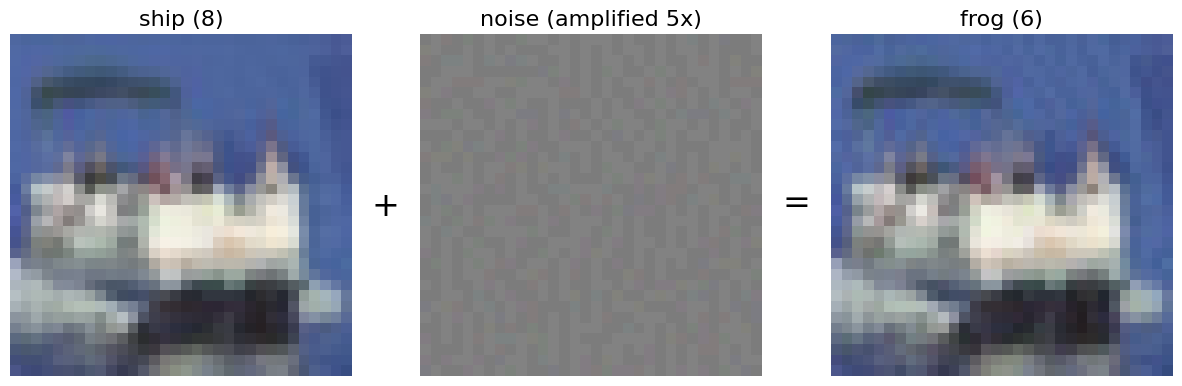

In [38]:
ifgsm(MikeTheModel, image, label, epsilon=0.005, sign=True)

While iFGSM can fool the model with an epsilon of 0.005 on this image of the ship, regular FGSM cannot.